In [138]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

In [139]:
%matplotlib inline

# Maximization Bias Example

<img src="files/maximization_bias_example.png">

States: A, B

Action A:
1. left => B (reward = 0)
2. right => the terminal state (reward = 0)
          
Action B: 
- choose one arm => the terminal state (reward ~ N(-0.1, 1)) 

In the following, we set 

state {0, 1, ,2 ,3}:
- state A = 0, the right terminal state = 1, state B = 2, the left terminal state = 3.


    - At state A(0), actions {0, 1}:
        - choosing right = 0, choosing left = 1.


    - At state B(2), actions {0, 1, 2, 3, 4}:
        - there are 5 arms, ordered by 0, 1, 2, 3, 4.

In [180]:
def Double_Q_update(Q1, Q2, s, a, r, transition, policy, α, γ):
    """
    Do one step update for value function Q1 at state-action pair (s, a),
    which uses value function Q2 to find the maximizer.
    
    Parameters
    ----------------
    Q1 : list(np.ndarray)
        value function to be updated. Q[s][a] is the value for state-action
        pair (s, a).
        
    Q2 : list(np.ndarray)
        value function for finding the maximizer at next period state `s_next`.
        
    s : int
        the current state.
    
    a : int
        the current action.
        
    r : float
        reward induced by chossing action `a` at state `s`.
        
    transition : list(np.ndarray)
        transition matrix that indicates the next state `s_next` by choosing action
        `a` at state `s`.
        
    policy : func
        policy function for choosing the optimal action if choose not to explore.
        
    α : float
        learning step size.
        
    γ : float
        discounting rate
    """
    s_next = transition[s][a]
    a_next = policy(Q1[s_next])
    
    Q1[s][a] += α * (r + γ * Q2[s_next][a_next] - Q1[s][a])
    
    return s_next

def Q_learning(Q, rewards, transition, policy, terminal_states, α, γ, ε, action, left_values, i_episode):
    """
    The standard Q learning algorithm.
    
    Parameters
    ----------------
    
    Q : list(np.ndarray)
        value function to be updated.
        
    rewards : func
        reward function which takes state-action pair (s, a) as argument.
        
    transition : list(np.ndarray)
        transition matrix that indicates the next state `s_next` by choosing action
        `a` at state `s`.
        
    policy : func
        policy function for choosing the optimal action if choose not to explore.
        
    terminal_states : list(int)
        list of terminal states.
        
    α : float
        learning step size.
        
    γ : float
        discounting rate
        
    ε : float
        exploration rate
        
    action : np.ndarray
        matrix for storing the action choice at state A (left or right) in different episodes
        and in different runs.
        
    action : np.ndarray
        matrix for storing the estimate of Q(A, left) in different episodes and in different runs.
        
    i_episode : int
        epsiode index.
    """
    # initial state
    s = 0   
    
    while True:
        
        # exploration
        if np.random.random() < ε:
            # if explore, choose randomly from available action set
            # A(s) = {0, ,1, ..., |Q[s]|-1}
            a = np.random.choice(len(Q[s]))
        else:
            # if do not explore, choose optimal action by policy function
            # e.g. greedy policy
            a = policy(Q[s])
        
        # record the choice of action at state A
        if s == 0:
            action[i_episode] = a
            
        r = rewards(s, a)
        # do one step update
        # in the standard Q learning, we set Q1=Q2=Q
        s_next = Double_Q_update(Q, Q, s, a, r, transition, policy, α, γ)
        
        # if next state is terminal state, then terminate episode
        if s_next in terminal_states:
            # record the estimate of Q(A, left) in each episode
            left_values[i_episode] = Q[0][1]
            break
        else:
            s = s_next
        
def Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, α, γ, ε, action, left_values, i_episode):
    """
    All the same with `Q_learning` except for that we have two value function Q1 and Q2, and
    each time one of them are chosen randomly to be updated.
    
    Parameters
    ----------------
    
    Q1 : list(np.ndarray)
        value function.
        
    Q2 : list(np.ndarray)
        value function.
    """
    # initial state
    s = 0
    
    while True:
        
        # exploration
        if np.random.random() < ε:
            a = np.random.choice(len(Q1[s]))
        else:
            a = policy(Q1[s]+Q2[s])
            
        if s == 0:
            action[i_episode] = a
            
        r = rewards(s, a)
        
        # randomly update Q1 or Q2
        if np.random.random() < ε:
            s_next = Double_Q_update(Q1, Q2, s, a, r, transition, policy, α, γ)
        else:
            s_next = Double_Q_update(Q2, Q1, s, a, r, transition, policy, α, γ)
            
        if s_next in terminal_states:
            left_values[i_episode] = (Q1[0][1] + Q2[0][1]) / 2
            break
        else:
            s = s_next
            
def Conditional_Path_Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, α, γ, ε, action, left_values, i_episode):
    """
    All the same with `Double_Q_learning` except for that Q1 and Q2 are chosen to be updated in turn,
    rather than randomly.
    """
    # initial state
    s = 0
    flag = 0
    
    while True:
        
        if flag == 0:
            # draw a random variable between 0 and 1 for determining
            # whether to explore or not
            # it is used twice for Q1 and Q2 in tunr
            rand = np.random.random()

        # exploration
        if rand < ε:
            a = np.random.choice(len(Q1[s]))
        else:
            a = policy(Q1[s]+Q2[s])
            
        if s == 0:
            action[i_episode] = a
            
        r = rewards(s, a)
        
        # update Q1 and Q2 in turn
        if flag == 0:
            s_next = Double_Q_update(Q1, Q2, s, a, r, transition, policy, α, γ)
            flag = 1
        else:
            s_next = Double_Q_update(Q2, Q1, s, a, r, transition, policy, α, γ)
            flag = 0
            
        if s_next in terminal_states:
            left_values[i_episode] = (Q1[0][1] + Q2[0][1]) / 2
            break
        else:
            s = s_next

In [181]:
@njit
def rewards(s, a):

    # state A
    if s == 0:
        return 0
    # state B
    elif s == 2:
        return np.random.normal(-0.1, 1)

# assume there are 5 actions at state B (2)
transition = [[1, 2], [], [3, 3, 3, 3, 3], []]

# greedy policy
policy = njit(lambda Q: np.argmax(np.random.random(len(Q)) * (Q == Q.max())))

# left and right terminal states
terminal_states = [1, 3]

In [182]:
N_runs = 10000
N_episodes = 600

action_Q = np.empty((N_runs, N_episodes))
left_values_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):

    Q = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Q_learning(Q, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Q[i], left_values_Q[i], j)

In [183]:
action_Double_Q = np.empty((N_runs, N_episodes))
left_values_Double_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q[i], left_values_Double_Q[i], j)

In [184]:
action_Double_Q_switch = np.empty((N_runs, N_episodes))
left_values_Double_Q_switch = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Conditional_Path_Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q_switch[i], left_values_Double_Q_switch[i], j)

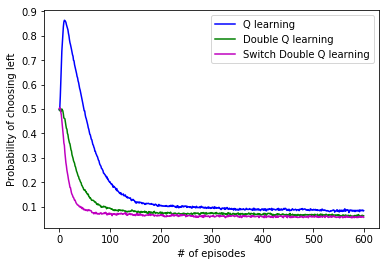

In [185]:
plt.plot(range(N_episodes), np.mean(action_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(action_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(action_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("Probability of choosing left");

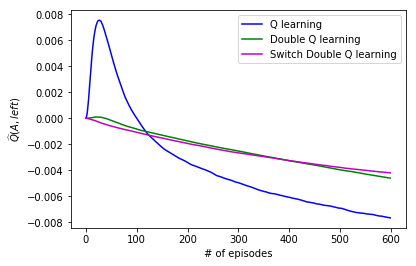

In [186]:
plt.plot(range(N_episodes), np.mean(left_values_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("$\widehat{Q}(A, left)$");

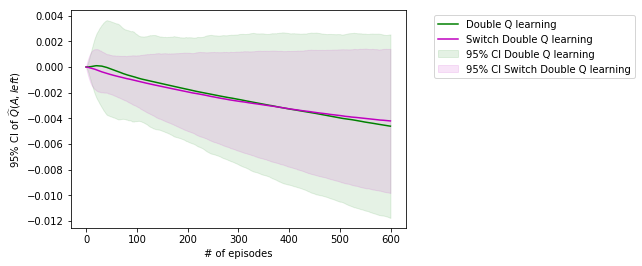

In [187]:
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), color = 'g', label="Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q, 0)-1.96*np.std(left_values_Double_Q, 0), np.mean(left_values_Double_Q, 0)+1.96*np.std(left_values_Double_Q, 0), color = 'g', alpha = 0.1, label = '95% CI Double Q learning')

plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), color = 'm', label="Switch Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q_switch, 0)-1.96*np.std(left_values_Double_Q_switch, 0), np.mean(left_values_Double_Q_switch, 0)+1.96*np.std(left_values_Double_Q_switch, 0), color = 'm', alpha = 0.1, label = '95% CI Switch Double Q learning')

plt.legend(bbox_to_anchor=(1.7, 1.))

plt.xlabel("# of episodes")
plt.ylabel("95% CI of $\widehat{Q}(A, left)$");

# Double Q Learning is not doing well when Q(left, a) ~ N(0.1, 1)

In [190]:
@njit
def rewards(s, a):

    # A
    if s == 0:
        return 0
    # B
    elif s == 2:
        return np.random.normal(0.1, 1)

# assume there are 5 actions at state 2 (left)
transition = [[1, 2], [], [3, 3, 3, 3, 3], []]

policy = njit(lambda Q: np.argmax(np.random.random(len(Q)) * (Q == Q.max())))

terminal_states = [1, 3]

In [191]:
N_runs = 10000
N_episodes = 1200

action_Q = np.empty((N_runs, N_episodes))
left_values_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):

    Q = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Q_learning(Q, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Q[i], left_values_Q[i], j)

In [192]:
action_Double_Q = np.empty((N_runs, N_episodes))
left_values_Double_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q[i], left_values_Double_Q[i], j)

In [193]:
action_Double_Q_switch = np.empty((N_runs, N_episodes))
left_values_Double_Q_switch = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Conditional_Path_Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q_switch[i], left_values_Double_Q_switch[i], j)

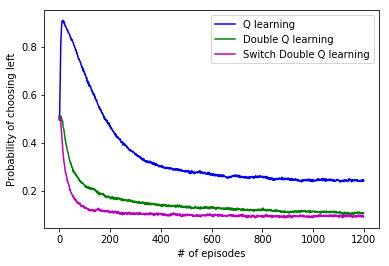

In [194]:
plt.plot(range(N_episodes), np.mean(action_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(action_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(action_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("Probability of choosing left");

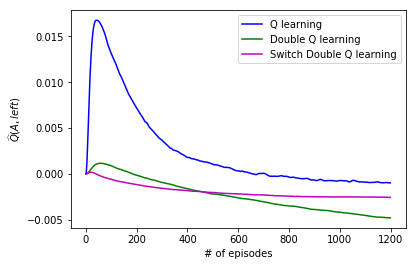

In [195]:
plt.plot(range(N_episodes), np.mean(left_values_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("$\widehat{Q}(A, left)$");

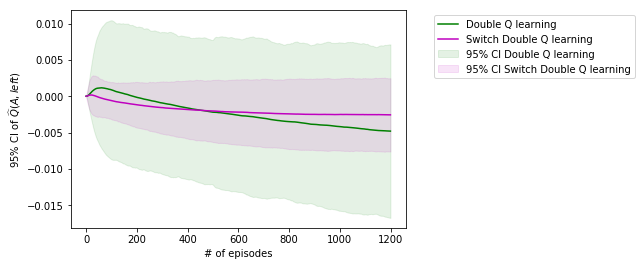

In [196]:
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), color = 'g', label="Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q, 0)-1.96*np.std(left_values_Double_Q, 0), np.mean(left_values_Double_Q, 0)+1.96*np.std(left_values_Double_Q, 0), color = 'g', alpha = 0.1, label = '95% CI Double Q learning')

plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), color = 'm', label="Switch Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q_switch, 0)-1.96*np.std(left_values_Double_Q_switch, 0), np.mean(left_values_Double_Q_switch, 0)+1.96*np.std(left_values_Double_Q_switch, 0), color = 'm', alpha = 0.1, label = '95% CI Switch Double Q learning')

plt.legend(bbox_to_anchor=(1.7, 1.))

plt.xlabel("# of episodes")
plt.ylabel("95% CI of $\widehat{Q}(A, left)$");

# Double Q Learning is not doing well when Q(left, a) ~ N(0.1, 1)

In [197]:
@njit
def rewards(s, a):

    # A
    if s == 0:
        return 0
    # B
    elif s == 2:
        return np.random.normal(1., 1)

# assume there are 5 actions at state 2 (left)
transition = [[1, 2], [], [3, 3, 3, 3, 3], []]

policy = njit(lambda Q: np.argmax(np.random.random(len(Q)) * (Q == Q.max())))

terminal_states = [1, 3]

In [198]:
N_runs = 10000
N_episodes = 300

action_Q = np.empty((N_runs, N_episodes))
left_values_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):

    Q = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Q_learning(Q, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Q[i], left_values_Q[i], j)

In [199]:
action_Double_Q = np.empty((N_runs, N_episodes))
left_values_Double_Q = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q[i], left_values_Double_Q[i], j)

In [200]:
action_Double_Q_switch = np.empty((N_runs, N_episodes))
left_values_Double_Q_switch = np.empty((N_runs, N_episodes))

for i in range(N_runs):
    
    Q1 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    Q2 = [np.zeros(2), np.zeros(1), np.zeros(5), np.zeros(1)]
    for j in range(N_episodes):
        Conditional_Path_Double_Q_learning(Q1, Q2, rewards, transition, policy, terminal_states, 0.1, 0.1, 0.1, action_Double_Q_switch[i], left_values_Double_Q_switch[i], j)

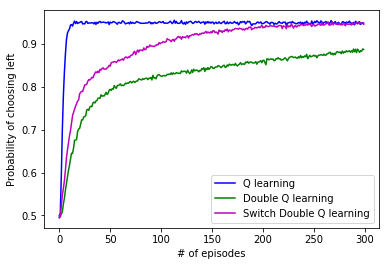

In [201]:
plt.plot(range(N_episodes), np.mean(action_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(action_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(action_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("Probability of choosing left");

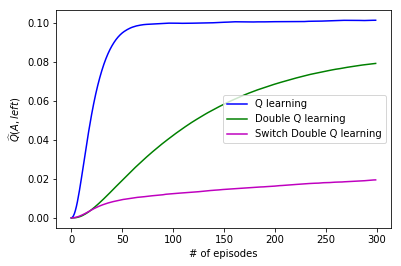

In [202]:
plt.plot(range(N_episodes), np.mean(left_values_Q, 0), label="Q learning", color='b')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), label="Double Q learning", color='g')
plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), label="Switch Double Q learning", color='m')

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("$\widehat{Q}(A, left)$");

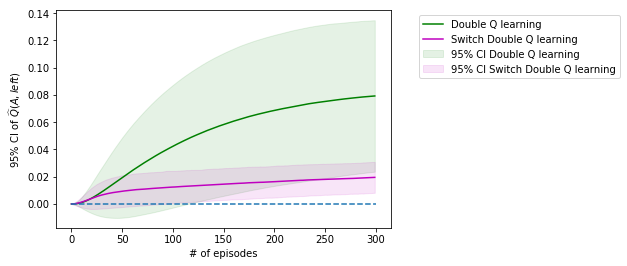

In [203]:
plt.plot(range(N_episodes), np.mean(left_values_Double_Q, 0), color = 'g', label="Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q, 0)-1.96*np.std(left_values_Double_Q, 0), np.mean(left_values_Double_Q, 0)+1.96*np.std(left_values_Double_Q, 0), color = 'g', alpha = 0.1, label = '95% CI Double Q learning')

plt.plot(range(N_episodes), np.mean(left_values_Double_Q_switch, 0), color = 'm', label="Switch Double Q learning")
plt.fill_between(range(N_episodes), np.mean(left_values_Double_Q_switch, 0)-1.96*np.std(left_values_Double_Q_switch, 0), np.mean(left_values_Double_Q_switch, 0)+1.96*np.std(left_values_Double_Q_switch, 0), color = 'm', alpha = 0.1, label = '95% CI Switch Double Q learning')

plt.plot([0, 300], [0, 0], '--')

plt.legend(bbox_to_anchor=(1.7, 1.))

plt.xlabel("# of episodes")
plt.ylabel("95% CI of $\widehat{Q}(A, left)$");

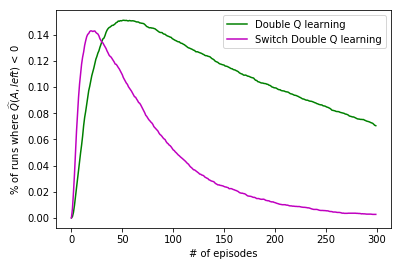

In [204]:
plt.plot(range(N_episodes), np.sum(left_values_Double_Q < 0, 0) / N_runs, color = 'g', label="Double Q learning")
plt.plot(range(N_episodes), np.sum(left_values_Double_Q_switch < 0, 0) / N_runs, color = 'm', label="Switch Double Q learning")

plt.legend()

plt.xlabel("# of episodes")
plt.ylabel("% of runs where $\widehat{Q}(A, left)$ < 0");